# Brownian Motion

Create simulation

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
from pygsig.graph import StaticGraphTemporalSignal
import torch_geometric.transforms as T
from pygsig.signature import SignatureFeatures, StatFeatures

# Simulation parameters

def run_simultion(num_nodes = 200,
                  p_across_blocks = 0.01,
                  p_within_blocks = 0.1,                  
                  dim = 2,
                  time_horizon = 10,
                  dt = 1e-3,
                  beta_gain = 5,
                  sigma_gain = 1,
                  simulation_seed=1,
                  target_seed=29,
                  graph_seed=29):
    
    num_time_steps = int(time_horizon / dt)

    def kuramoto(graph, theta, omega, dt):
        deg = dict(graph.degree())
        dtheta = np.zeros_like(theta)
        for u, v, data in graph.edges(data=True):
            coupling = data['weight']
            dtheta[u] += dt * (omega[u]  + (1/deg[u]) * coupling * np.sin(theta[v] - theta[u]))
            dtheta[v] += dt * (omega[v]  + (1/deg[v]) * coupling * np.sin(theta[u] - theta[v]))
        return theta + dtheta

    def periodic_drift(beta, theta, omega,mu_0, t):
        return mu_0 + beta*np.sin(omega*t + theta)

    # Create a graph

    block_sizes = [num_nodes//3,num_nodes//3,num_nodes//3]
    block_probs = [[p_within_blocks, p_across_blocks, p_across_blocks],
                   [p_across_blocks, p_within_blocks, p_across_blocks],
                   [p_across_blocks, p_across_blocks, p_within_blocks]]
    graph = nx.stochastic_block_model(block_sizes, block_probs, seed=graph_seed)

    for edge in graph.edges:
        graph[edge[0]][edge[1]]['weight'] = 1
    
     # Nature frequency (target variable)
    np.random.seed(target_seed)
    for node in graph.nodes:
        if graph.nodes[node]['block'] == 0:
            graph.nodes[node]['omega'] = 0.25 + np.random.randn() * 0.0
        if graph.nodes[node]['block'] == 1:
            graph.nodes[node]['omega'] = 0.50 + np.random.randn() * 0.0
        if graph.nodes[node]['block'] == 2:
            graph.nodes[node]['omega'] = 0.75 + np.random.randn() * 0.0

    
    # Othe oscilator perameters
    np.random.seed(simulation_seed)
    omega = np.stack([np.ones(dim) * graph.nodes[node]['omega'] for node in graph.nodes])
    theta = 2 * np.pi * np.random.rand(num_nodes,dim)  # Initial phases
    beta =  beta_gain * np.ones((num_nodes,dim)) # amplitude
    mu_initial = np.random.rand(num_nodes,dim) # initial drift

    # brownian motion parameters
    X = np.random.rand(num_nodes,dim) # signal
    drift = np.random.rand(num_nodes,dim) # drift
    sigma = sigma_gain * np.eye(dim) # diffusion matrix

    # Simulate
    theta_traj = np.zeros((num_nodes,num_time_steps,dim))
    mu_traj = np.zeros((num_nodes,num_time_steps,dim))
    paths = np.zeros((num_nodes,num_time_steps, dim))

    # Time sequence
    tt = np.linspace(0, time_horizon, num_time_steps)

    for step,t in enumerate(tt):
        theta_traj[:, step] = theta
        mu_traj[:,step] = drift
        paths[:,step,:] = X
        theta = kuramoto(graph, theta, omega,dt)
        drift = periodic_drift(beta, theta,omega, mu_initial, t)
        X = X + dt * drift + np.sqrt(dt) * np.random.randn(num_nodes,dim) @ sigma

    return paths, omega , graph

def get_sequence(paths,graph):
    snapshot_count = paths.shape[1]
    df_edge = nx.to_pandas_edgelist(graph.to_directed())
    edge_index = torch.tensor(df_edge[['source','target']].values.T,dtype=torch.long)
    edge_weight = torch.tensor(df_edge['weight'].values,dtype=torch.float)
    snapshot_count = paths.shape[1]
    features = [ paths[:,t,:] for t in range(snapshot_count)]
    targets = [ torch.tensor(np.array([graph.nodes[node]['omega'] for node in graph.nodes]),dtype=torch.float).unsqueeze(-1) for _ in range(snapshot_count)]
    # Sequential Data
    return StaticGraphTemporalSignal(edge_index=edge_index,edge_weight=edge_weight,features=features,targets=targets)


Make dataset consisting of multiple SDE trajectories

In [2]:
from tqdm import tqdm

num_runs = 20
num_nodes = 300
seq_dataset = []

betas = np.random.choice([0.1,0.5,1,2,5],num_runs)
sigmas = np.random.choice([0.1,0.5,1,2,5],num_runs)

with tqdm(total=num_runs) as pbar:
    for run in range(num_runs):
        paths, omega, graph = run_simultion(num_nodes = num_nodes,
                                            p_across_blocks = 0.05,
                                            p_within_blocks = 0.1,
                                            dim = 2,
                                            time_horizon = 2,
                                            dt = 1e-3,
                                            beta_gain=betas[run],
                                            sigma_gain=sigmas[run],
                                            simulation_seed=29+run,
                                            target_seed=29+run,
                                            graph_seed=29)
        
        seq = get_sequence(paths,graph)
        seq_dataset.append(seq)
        pbar.update(1)

100%|██████████| 20/20 [09:16<00:00, 27.84s/it]


save dataset

In [3]:
import torch
torch.save(seq_dataset,'datasets/brownian/brownian-2d-3b.pt')

load dataset

In [3]:
import torch
seq_dataset = torch.load('datasets/brownian/brownian-2d-3b.pt')
seq_dataset = [seq_dataset[0]]

### Linear interpolation

100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Number of parameters: 4417
Signature depth: 1
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]

MSE: 0.0421 ± 0.0085, MAE: 0.1700 ± 0.0331 


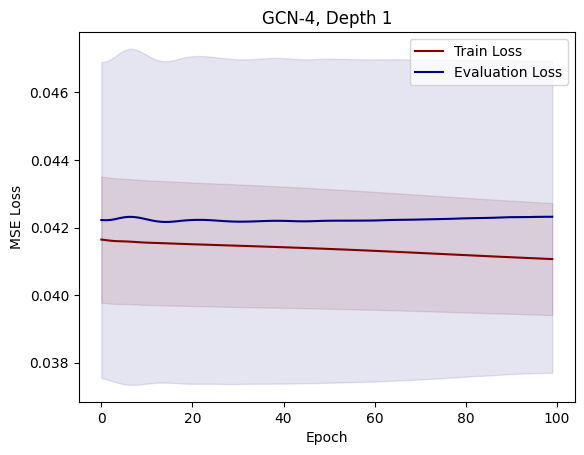

100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Number of parameters: 4673
Signature depth: 2
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]

MSE: 0.0402 ± 0.0076, MAE: 0.1705 ± 0.0288 


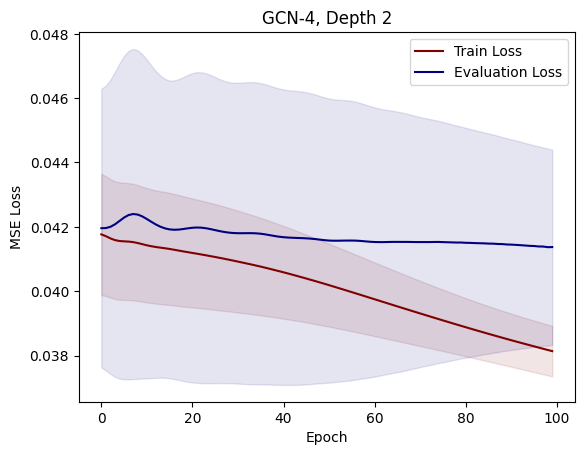

100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Number of parameters: 5185
Signature depth: 3
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]

MSE: 0.0344 ± 0.0069, MAE: 0.1621 ± 0.0229 


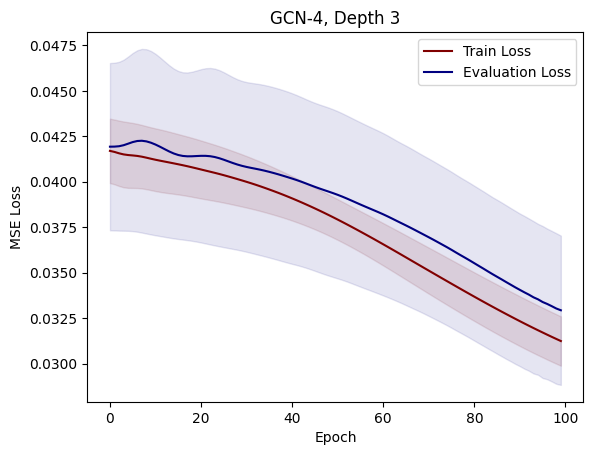

100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Number of parameters: 6209
Signature depth: 4
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]

MSE: 0.0332 ± 0.0074, MAE: 0.1555 ± 0.0236 


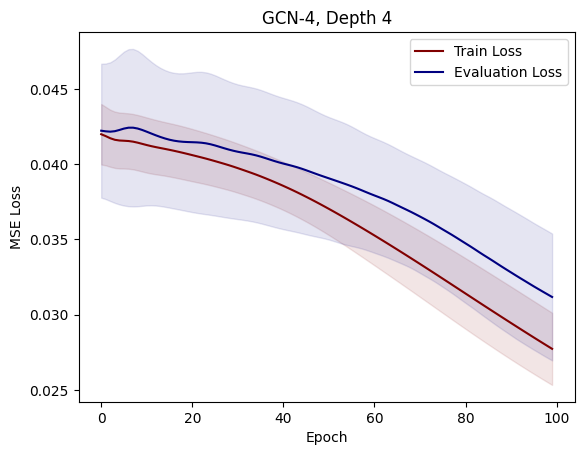

100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Number of parameters: 8257
Signature depth: 5
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]

MSE: 0.0277 ± 0.0077, MAE: 0.1382 ± 0.0222 


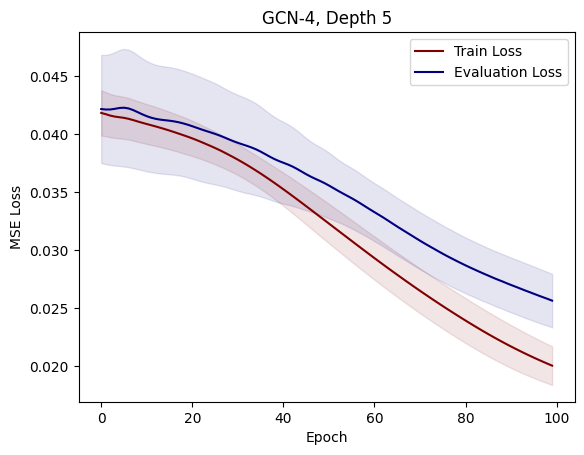

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Number of parameters: 12353
Signature depth: 6
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]

MSE: 0.0260 ± 0.0087, MAE: 0.1308 ± 0.0240 


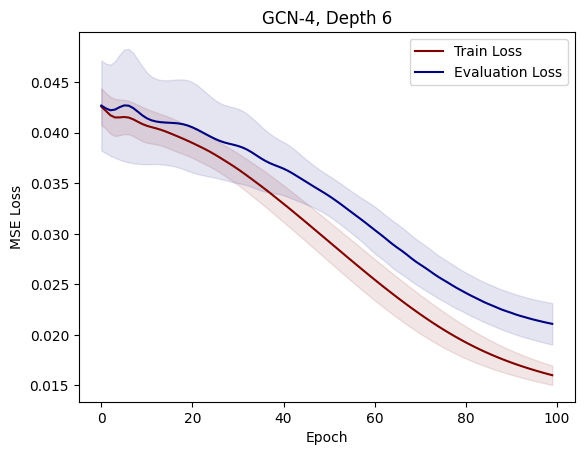

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Number of parameters: 20545
Signature depth: 7
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]

MSE: 0.0246 ± 0.0065, MAE: 0.1255 ± 0.0190 


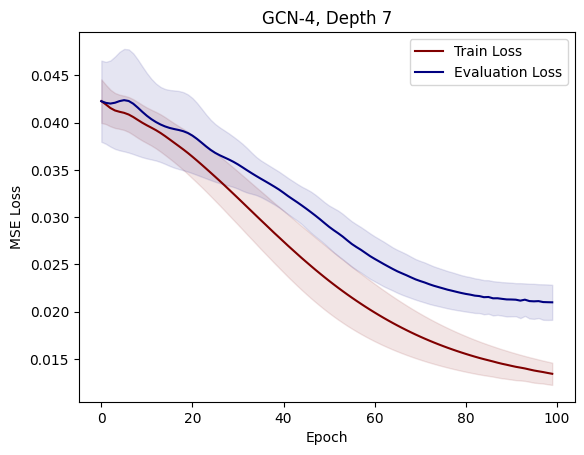

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Number of parameters: 36929
Signature depth: 8
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:08<00:00,  1.90it/s]

MSE: 0.0251 ± 0.0068, MAE: 0.1268 ± 0.0193 


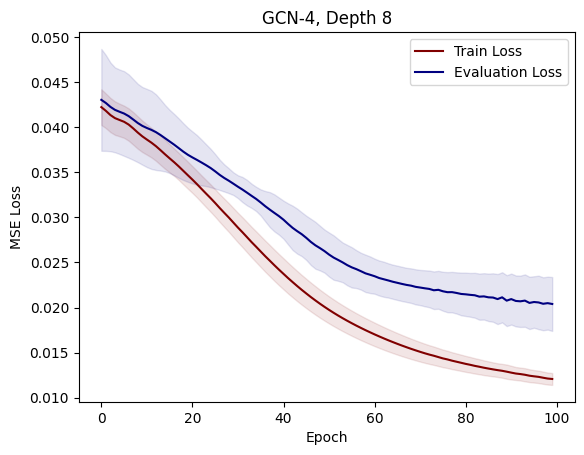

In [7]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNShallowRegression,GCNRegression
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
num_splits = 4 # split the data into 4 groups
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 100

learning_rate = 1e-3
lasso = 1e-4
num_hidden = 64

print_during_training = False


mse_depth = []
mae_depth = []

for signature_depth in range(1,9):

    # convert the dataset to the signature space
    dataset = []
    for seq in tqdm(seq_dataset):
        signature_transform = SignatureFeatures(sig_depth=signature_depth, normalize=True, log_signature=False,lead_lag=False)
        dataset.append(signature_transform(seq))
    
    # model
    model = GCNRegression(num_channels=[dataset[0].num_node_features, num_hidden,num_hidden, 1])
    # training
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Signature depth: {signature_depth}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    criterion = nn.MSELoss() # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) # optimizer
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) # array storing the train loss for each split, run, trial, epoch
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    mse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        mse[split, run, trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                        mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])

    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f} ')  
    mse_depth.append(mse)
    mae_depth.append(mae)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    std_eval_losses = np.std(eval_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'GCN-4, Depth {signature_depth}')
    plt.legend()
    plt.show()

### Lead-lag transformation

100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Number of parameters: 4545
Signature depth: 1
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:08<00:00,  1.87it/s]

MSE: 0.0421 ± 0.0084, MAE: 0.1705 ± 0.0325 


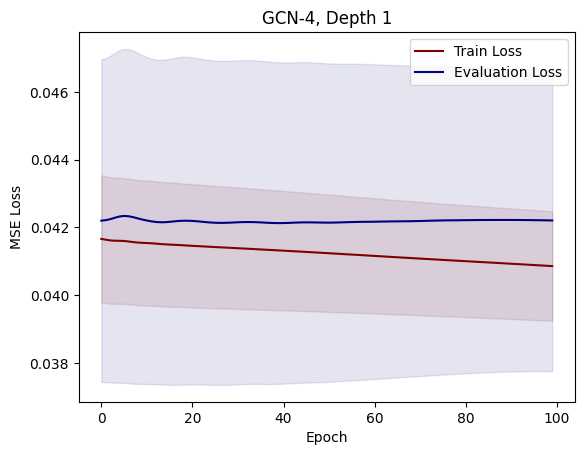

100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Number of parameters: 5569
Signature depth: 2
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]

MSE: 0.0374 ± 0.0063, MAE: 0.1660 ± 0.0258 


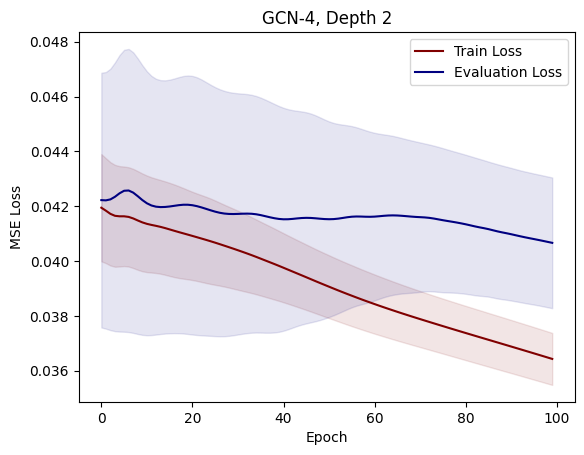

100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Number of parameters: 9665
Signature depth: 3
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]

MSE: 0.0315 ± 0.0075, MAE: 0.1534 ± 0.0211 


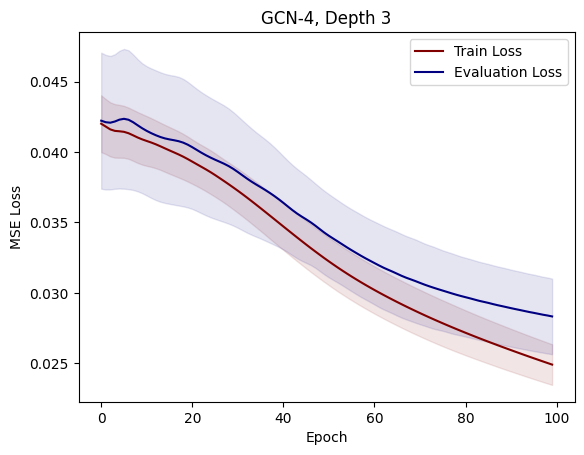

100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Number of parameters: 26049
Signature depth: 4
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:07<00:00,  2.05it/s]

MSE: 0.0260 ± 0.0058, MAE: 0.1313 ± 0.0157 


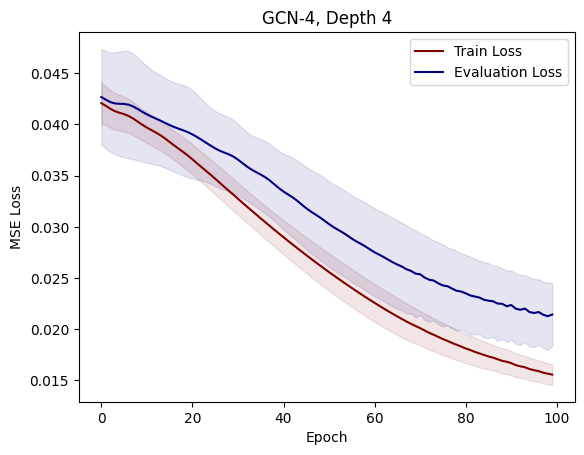

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Number of parameters: 91585
Signature depth: 5
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:08<00:00,  1.78it/s]

MSE: 0.0250 ± 0.0054, MAE: 0.1260 ± 0.0166 


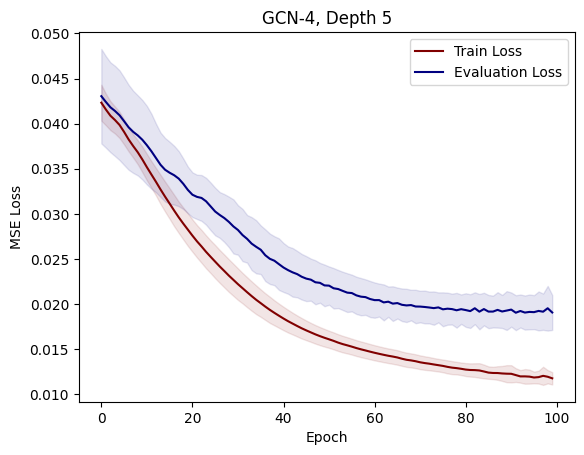

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Number of parameters: 353729
Signature depth: 6
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:11<00:00,  1.39it/s]

MSE: 0.0251 ± 0.0057, MAE: 0.1290 ± 0.0143 


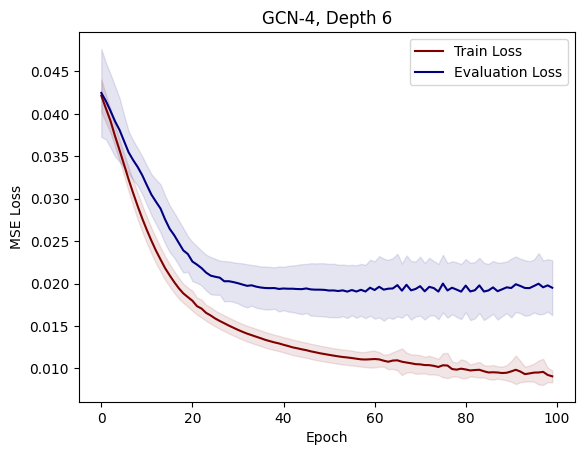

100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Number of parameters: 1402305
Signature depth: 7
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:22<00:00,  1.43s/it]

MSE: 0.0235 ± 0.0059, MAE: 0.1221 ± 0.0150 


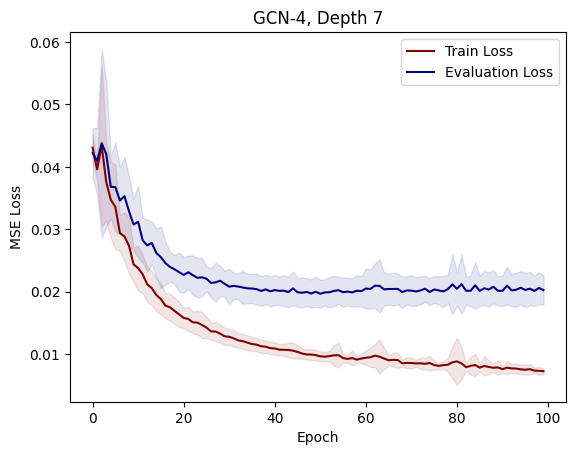

100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


Number of parameters: 5596609
Signature depth: 8
Splits: 4, Trials: 4, Runs: 1, Epochs: 100


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]

MSE: 0.0232 ± 0.0058, MAE: 0.1208 ± 0.0176 


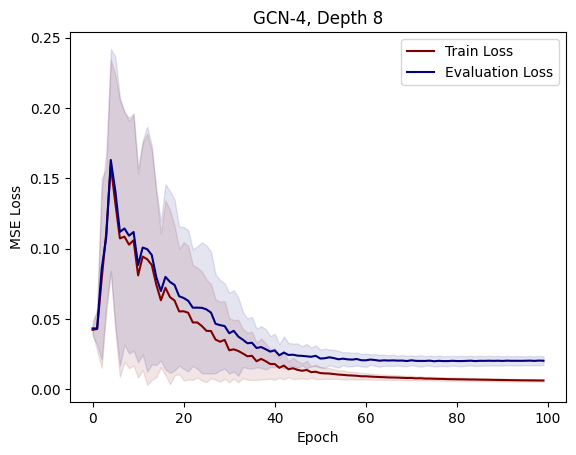

In [48]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric.transforms as T


import pygsig.graph 
import pygsig.models
import pygsig.signature
from pygsig.models import GCNShallowRegression,GCNRegression
from pygsig.graph import  split_nodes

import importlib
importlib.reload(pygsig.models)
importlib.reload(pygsig.signature)
importlib.reload(pygsig.graph)

num_nodes = seq_dataset[0].num_nodes
dim = seq_dataset[0].num_node_features
num_splits = 4 # split the data into 4 groups
num_runs = len(seq_dataset)
num_trials = 4
num_epochs = 100

learning_rate = 1e-3
lasso = 1e-4
num_hidden = 64

print_during_training = False


mse_depth_leadlag = []
mae_depth_leadlag = []

for signature_depth in range(1,9):

    # convert the dataset to the signature space
    dataset = []
    for seq in tqdm(seq_dataset):
        signature_transform = SignatureFeatures(sig_depth=signature_depth, normalize=True, log_signature=False,lead_lag=True)
        dataset.append(signature_transform(seq))
    
    # model
    model = GCNRegression(num_channels=[dataset[0].num_node_features, num_hidden,num_hidden, 1])
    # training
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Signature depth: {signature_depth}")
    print(f"Splits: {num_splits}, Trials: {num_trials}, Runs: {num_runs}, Epochs: {num_epochs}")
    criterion = nn.MSELoss() # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=lasso) # optimizer
    train_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs]) # array storing the train loss for each split, run, trial, epoch
    eval_losses = np.zeros([num_splits, num_runs, num_trials, num_epochs])
    mse = np.zeros([num_splits, num_runs, num_trials])
    mae = np.zeros([num_splits, num_runs, num_trials])

    with tqdm(total=num_splits*num_runs*num_trials, disable=print_during_training) as pbar:
        splits = split_nodes(num_nodes, num_splits,seed=29)
        for split in range(num_splits):
            train_indices, eval_indices, test_indices = splits[split]
            train_mask = torch.zeros(num_nodes, dtype=torch.bool)
            eval_mask = torch.zeros(num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(num_nodes, dtype=torch.bool)
            train_mask[train_indices] = True
            eval_mask[eval_indices] = True
            test_mask[test_indices] = True
            for run, data in enumerate(dataset):
                for trial in range(num_trials):
                    model.reset_parameters()
                    for epoch in range(num_epochs):
                        # train
                        model.train()
                        optimizer.zero_grad()
                        out = model(data.x, data.edge_index)
                        train_loss = criterion(out[train_mask], data.y[train_mask])
                        train_loss.backward()
                        optimizer.step()
                        # evaluate
                        model.eval()
                        with torch.no_grad():
                            eval_loss = criterion(out[eval_mask], data.y[eval_mask])
                            train_losses[split, run, trial, epoch] = train_loss.item()
                            eval_losses[split, run, trial, epoch] = eval_loss.item()
                        if epoch % 10 == 0 and print_during_training:
                            print(f'Split {split}, Run {run}, Trial {trial}, Epoch {epoch}, Train MSE Loss: {train_loss.item():.4f}, Evaulation MSE Loss: {eval_loss.item():.4f}')
                    pbar.update(1)
                    # compute the errors on the testing loss after the last epoch
                    with torch.no_grad():
                        out = model(data.x, data.edge_index)
                        mse[split, run, trial] = mean_squared_error(data.y[test_mask], out[test_mask])
                        mae[split, run, trial] = mean_absolute_error(data.y[test_mask], out[test_mask])

    print(f'MSE: {np.mean(mse):.4f} ± {np.std(mse):.4f}, MAE: {np.mean(mae):.4f} ± {np.std(mae):.4f} ')  
    mse_depth_leadlag.append(mse)
    mae_depth_leadlag.append(mae)

    # Plotting
    avg_train_losses = np.mean(train_losses, axis=(0,1,2))
    avg_eval_losses = np.mean(eval_losses, axis=(0,1,2))
    std_train_losses = np.std(train_losses, axis=(0,1,2))
    std_eval_losses = np.std(eval_losses, axis=(0,1,2))
    
    plt.figure()
    plt.plot(avg_train_losses,  label='Train Loss', color='maroon')
    plt.plot(avg_eval_losses,  label='Evaluation Loss', color='navy')
    plt.fill_between(range(num_epochs), avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, alpha=0.1, color='maroon')
    plt.fill_between(range(num_epochs), avg_eval_losses - std_eval_losses, avg_eval_losses + std_eval_losses, alpha=0.1,color='navy')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'GCN-4, Depth {signature_depth}')
    plt.legend()
    plt.show()

In [59]:
MSE1= np.array(mse_depth)
MAE1 = np.array(mae_depth)
MSE2 = np.array(mse_depth_leadlag)
MAE2 = np.array(mae_depth_leadlag)

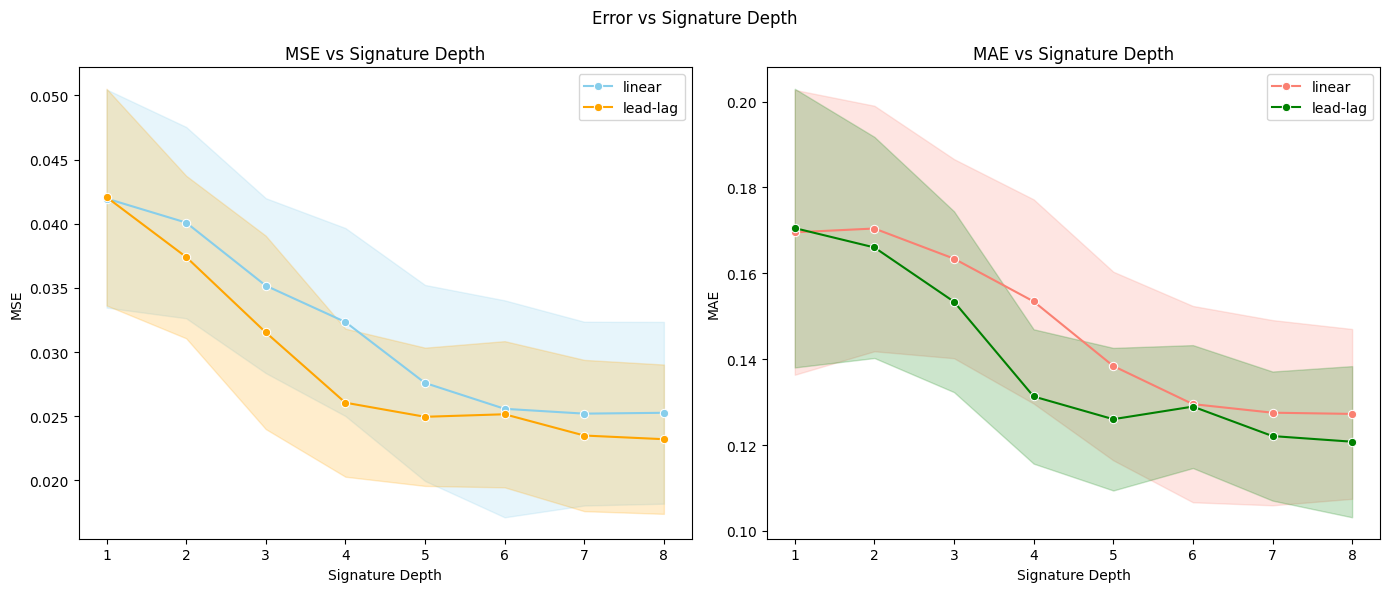

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


mean_MSE1 = np.mean(MSE1, axis=(1, 2, 3))
std_MSE1 = np.std(MSE1, axis=(1, 2, 3))
mean_MAE1 = np.mean(MAE1, axis=(1, 2, 3))
std_MAE1 = np.std(MAE1, axis=(1, 2, 3))
mean_MSE2 = np.mean(MSE2, axis=(1, 2, 3))
std_MSE2 = np.std(MSE2, axis=(1, 2, 3))
mean_MAE2 = np.mean(MAE2, axis=(1, 2, 3))
std_MAE2 = np.std(MAE2, axis=(1, 2, 3))

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot MSE
axs[0].set_title('MSE vs Signature Depth')
sns.lineplot(x=range(1, 9), y=mean_MSE1, label='linear', color='salmon', marker='o', ax=axs[0])
axs[0].fill_between(range(1, 9), mean_MSE1 - std_MSE1, mean_MSE1 + std_MSE1, color='salmon', alpha=0.2)
sns.lineplot(x=range(1, 9), y=mean_MSE2, label='lead-lag', color='green', marker='o', ax=axs[0])
axs[0].fill_between(range(1, 9), mean_MSE2 - std_MSE2, mean_MSE2 + std_MSE2, color='green', alpha=0.2)
axs[0].set_xlabel('Signature Depth')
axs[0].set_ylabel('MSE')
axs[0].legend()

# Plot MAE
axs[1].set_title('MAE vs Signature Depth')
sns.lineplot(x=range(1, 9), y=mean_MAE1, label='linear', color='salmon', marker='o', ax=axs[1])
axs[1].fill_between(range(1, 9), mean_MAE1 - std_MAE1, mean_MAE1 + std_MAE1, color='salmon', alpha=0.2)
sns.lineplot(x=range(1, 9), y=mean_MAE2, label='lead-lag', color='green', marker='o', ax=axs[1])
axs[1].fill_between(range(1, 9), mean_MAE2 - std_MAE2, mean_MAE2 + std_MAE2, color='green', alpha=0.2)
axs[1].set_xlabel('Signature Depth')
axs[1].set_ylabel('MAE')
axs[1].legend()

plt.suptitle('Error vs Signature Depth')
plt.tight_layout()
plt.show()
